<a href="https://colab.research.google.com/github/shakasom/MapsDataScience/blob/master/Chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making sense of humongous location datasets

## Installations

The geospatial libraries are not pre installed in google colab as standard python library, therefore we need to install some libraries to use. Luckily this is an easy process. You can use either apt install or pip install. You can also create anaconda environment, but that is a bit complex so pip and apt are enough in our case to get the libraries we need. These are the libraries we need to install in this tutorial:

Gdal Geopandas Folium

The installation might take 1 minute.

In [0]:
%%time 
!apt update --quiet
!apt upgrade --quiet
# GDAL Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal --quiet
# Install rtree - Geopandas requirment
!apt install python3-rtree --quiet
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet
# Install descartes - Geopandas requirment
!pip install descartes --quiet
# Install Folium for Geographic data visualization
!pip install folium --quiet
# Install Pysal
!pip install pysal --quiet
# Install splot --> pysal
!pip install splot --quiet
# Install mapclassify
!pip install mapclassify --quiet

In [137]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pysal.explore import esda
from pysal.lib import weights
#import libysal as lps
from pysal.viz.splot.esda import plot_moran, plot_local_autocorrelation, lisa_cluster
import matplotlib
import matplotlib.pyplot as plt 
import folium
import os
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

import pysal as ps
ps.__version__

'2.0.0'

## Data 

The dataset for this chapter is stored in the dropbox link. It is a valuable skill to learn how to access data on the web, so we will use WGET. WGET is great utility in accessing files from the web and supports different protocols. 


In [0]:
# Get the data from dropbox link
!wget https://www.dropbox.com/s/xvs0ybc402mkrn8/2019-02-avon-and-somerset-street.zip --quiet

In [12]:
# see the folders available
import os
os.listdir(os.getcwd())

['.config',
 '2019-02-avon-and-somerset-street.zip',
 'Foursquare_2014_NYC.zip',
 'dataset_TSMC2014_NYC.txt',
 'sample_data']

In [14]:
# We have zipped data so let us unzip it
!unzip 2019-02-avon-and-somerset-street.zip 

Archive:  2019-02-avon-and-somerset-street.zip
  inflating: 2019-02-avon-and-somerset-street.csv  


In [15]:
crime_somerset = pd.read_csv("2019-02-avon-and-somerset-street.csv")
crime_somerset.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
1,NaN,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
2,NaN,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
3,NaN,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
4,NaN,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN


In [16]:
crime_somerset.shape

(13183, 12)

In [17]:
crime_somerset.isnull().sum()

Crime ID                  2608
Month                        0
Reported by                  0
Falls within                 0
Longitude                 1400
Latitude                  1400
Location                     0
LSOA code                 1400
LSOA name                 1400
Crime type                   0
Last outcome category     2608
Context                  13183
dtype: int64

In [0]:
# Drop columns with high missing values
crime_somerset.drop(['Last outcome category','Context', 'Crime ID' ], axis=1, inplace=True)

In [19]:
crime_somerset.head()

,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type
0,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
1,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
2,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
3,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
4,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour


In [20]:
crime_somerset.isnull().sum()

Month              0
Reported by        0
Falls within       0
Longitude       1400
Latitude        1400
Location           0
LSOA code       1400
LSOA name       1400
Crime type         0
dtype: int64

In [0]:
# Drop rows with missin values
crime_somerset.dropna(axis=0,inplace=True)

In [22]:
crime_somerset.isnull().sum()

Month           0
Reported by     0
Falls within    0
Longitude       0
Latitude        0
Location        0
LSOA code       0
LSOA name       0
Crime type      0
dtype: int64

In [23]:
crime_somerset.shape


(11783, 9)

In [24]:
crime_somerset.head()

,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type
0,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
1,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
2,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
3,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour
4,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour


### Convert to GeoDataFrame

In [0]:
# Function to create a Geodataframe
def create_gdf(df, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

In [26]:
crime_somerset_gdf = create_gdf(crime_somerset, 'Latitude', 'Longitude')
crime_somerset_gdf.head()

,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,geometry
0,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.515072 51.419357)
1,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.516919 51.423683)
2,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.516919 51.423683)
3,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.509384 51.40959)
4,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.509126 51.416137)


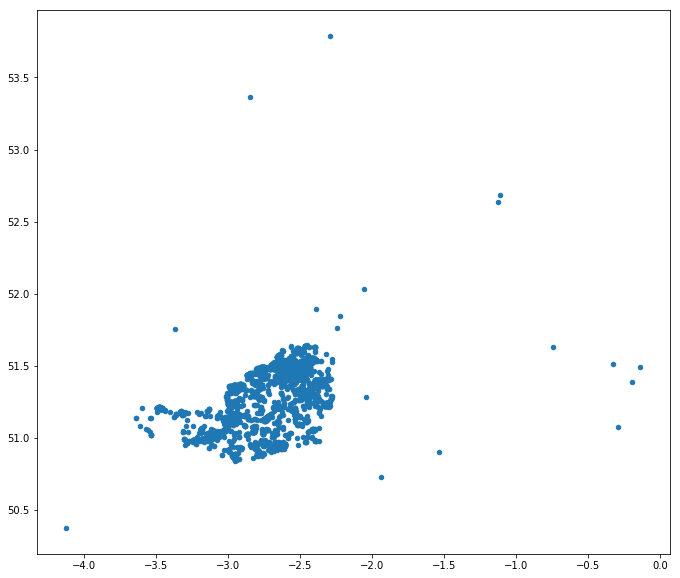

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
crime_somerset_gdf.plot(markersize=20, ax=ax);
plt.savefig('crime_somerset_map.png', bbox_inches='tight')

## KMeans Clustering Location Data

In [29]:
crime_somerset_gdf.head()

,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,geometry
0,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.515072,51.419357,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.515072 51.419357)
1,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.516919 51.423683)
2,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.516919,51.423683,On or near A4175,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.516919 51.423683)
3,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.509384 51.40959)
4,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,POINT (-2.509126 51.416137)


* Split training and test dataset

In [30]:
train = crime_somerset_gdf.sample(frac=0.7, random_state=14)
test = crime_somerset_gdf.drop(train.index)
train.shape, test.shape

((8248, 10), (3535, 10))

In [0]:
# Get coordinates for the train and test dataset
train_coords = train[['Latitude', 'Longitude']].values
test_coords = test[['Latitude', 'Longitude']].values

In [32]:
# Fit Kmeans clustering on training dataset
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_coords)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
# Predict on the test dataset by clustering 
preds = kmeans.predict(test_coords)

# Get centers of the clusters
centers = kmeans.cluster_centers_

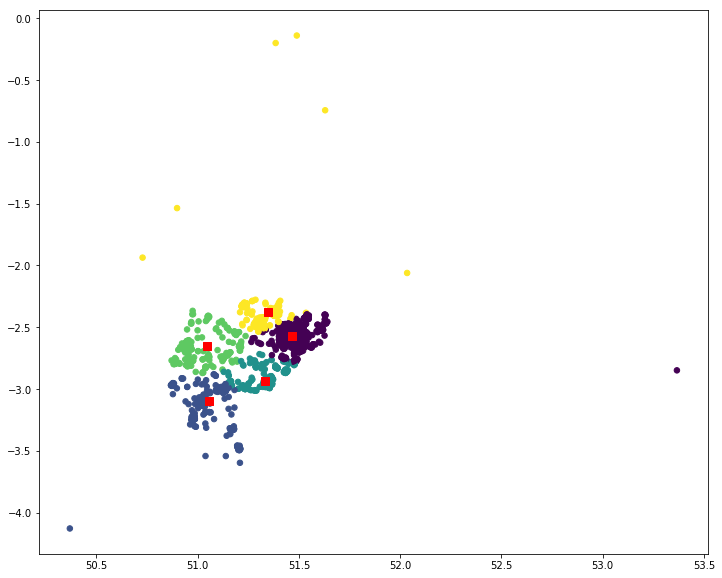

In [40]:
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(test_coords[:, 0], test_coords[:, 1], c=preds, s=30, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='Red', marker="s", s=50);

## DBSCAN 

### Detecting Outliers/Noise

In [41]:
coords = crime_somerset_gdf[['Latitude', 'Longitude']]
coords[:5]

,Latitude,Longitude
0,51.419357,-2.515072
1,51.423683,-2.516919
2,51.423683,-2.516919
3,51.409590,-2.509384
4,51.416137,-2.509126


In [0]:
# Get labels of each cluster 
_, labels  = dbscan(crime_somerset_gdf[['Latitude', 'Longitude']], eps=0.1, min_samples=10)


In [43]:
# Create a labels dataframe with the index of the dataset
labels_df = pd.DataFrame(labels, index=crime_somerset_gdf.index, columns=['cluster'])
labels_df.head()

,cluster
0,0
1,0
2,0
3,0
4,0


In [44]:
# Groupby Labels
labels_df.groupby('cluster').size()

cluster
-1       18
 0    11765
dtype: int64

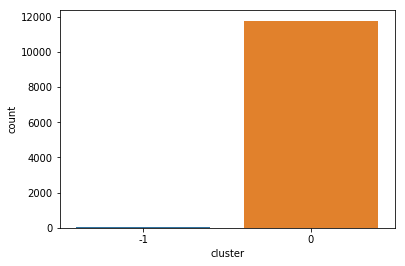

In [45]:
# Plot the groupedby labels
sns.countplot(labels_df.cluster);
plt.show()

In [0]:
# Get Noise (Outliers) with label -1 
noise = crime_somerset_gdf.loc[labels_df['cluster']==-1, ['Latitude', 'Longitude']]

# Get core with labels 0
core = crime_somerset_gdf.loc[labels_df['cluster']== 0, ['Latitude', 'Longitude']]

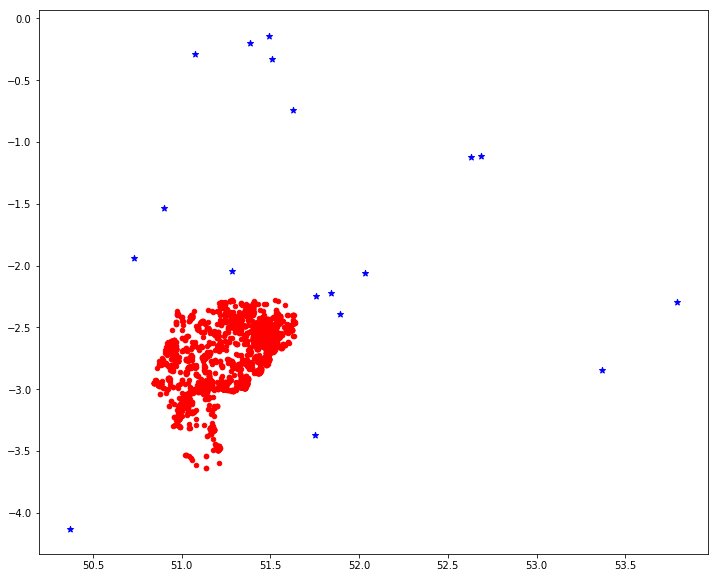

In [50]:
# Display scatter plot with noises as stars and core as circle points

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(noise['Latitude'], noise['Longitude'],marker= '*', s=40, c='blue' )
ax.scatter(core['Latitude'], core['Longitude'], marker= 'o', s=20, c='red')
plt.savefig('outliers.png');
plt.show();


In [51]:
noise

,Latitude,Longitude
5515,53.791463,-2.292410
5516,52.684583,-1.115782
5517,51.509993,-0.326819
5518,51.890164,-2.393020
5519,51.842758,-2.223547
5520,51.072400,-0.291105
5521,53.366498,-2.848328
5522,52.633265,-1.125106
6156,51.752409,-3.372417
6158,50.898266,-1.535575


### Detecting Clusters

In [62]:
_, labels  = dbscan(crime_somerset_gdf[['Latitude', 'Longitude']], eps=0.01, min_samples=300)
labels_df = pd.DataFrame(labels, index=crime_somerset_gdf.index, columns=['cluster'])
labels_df.groupby('cluster').size()

cluster
-1    8847
 0     419
 1    1756
 2     380
 3     381
dtype: int64

In [0]:
noise = crime_somerset_gdf.loc[labels_df['cluster']==-1, ['Latitude', 'Longitude']]
core = crime_somerset_gdf.loc[labels_df['cluster']== 0, ['Latitude', 'Longitude']]
bp1 = crime_somerset_gdf.loc[labels_df['cluster']== 1, ['Latitude', 'Longitude']]
bp2 = crime_somerset_gdf.loc[labels_df['cluster']== 2, ['Latitude', 'Longitude']]
bp3 = crime_somerset_gdf.loc[labels_df['cluster']== 3, ['Latitude', 'Longitude']]


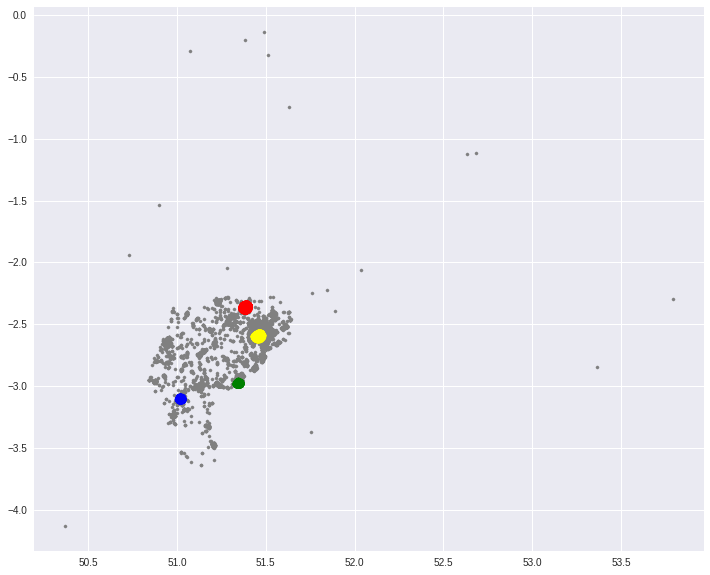

In [0]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(noise['Latitude'], noise['Longitude'], markers=10, c='gray' )
ax.scatter(core['Latitude'], core['Longitude'], s=100, c='red')
ax.scatter(bp1['Latitude'], bp1['Longitude'], s=50, c='yellow')
ax.scatter(bp2['Latitude'], bp2['Longitude'], s=50, c='green')
ax.scatter(bp3['Latitude'], bp3['Longitude'], s=50, c='blue')
plt.savefig('cluster_ex1.png');
plt.show()


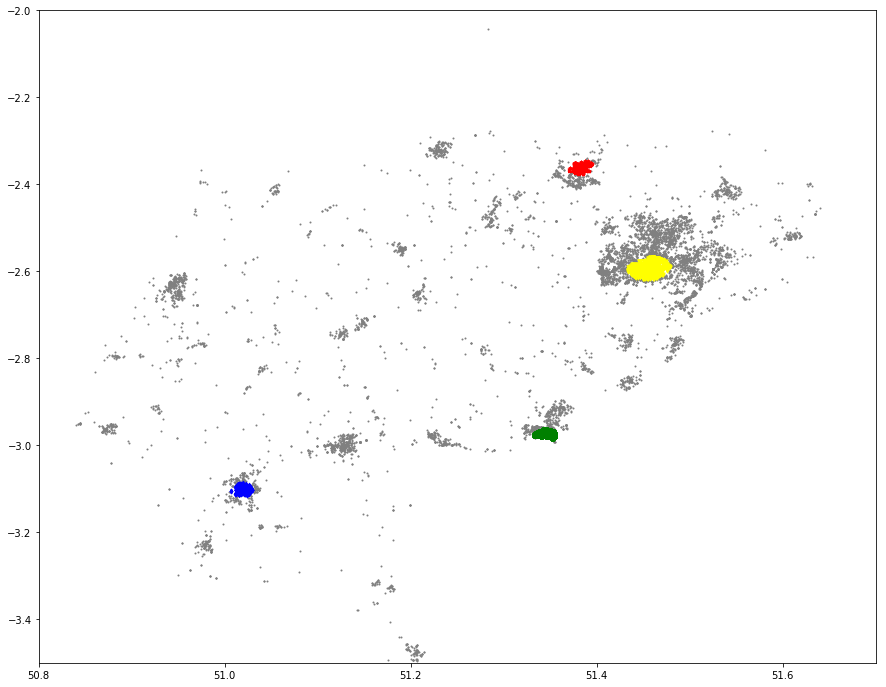

In [96]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(noise['Latitude'], noise['Longitude'],s=1, c='gray' )
ax.scatter(core['Latitude'], core['Longitude'],marker= "*", s=10, c='red')
ax.scatter(bp1['Latitude'], bp1['Longitude'], marker = "v", s=10, c='yellow')
ax.scatter(bp2['Latitude'], bp2['Longitude'], marker= "P", s=10, c='green')
ax.scatter(bp3['Latitude'], bp3['Longitude'], marker= "d", s=10, c='blue')
ax.set_xlim(left=50.8, right=51.7)
ax.set_ylim(bottom=-3.5, top=-2.0)
plt.savefig('cluster_zoomed.png');
plt.show()


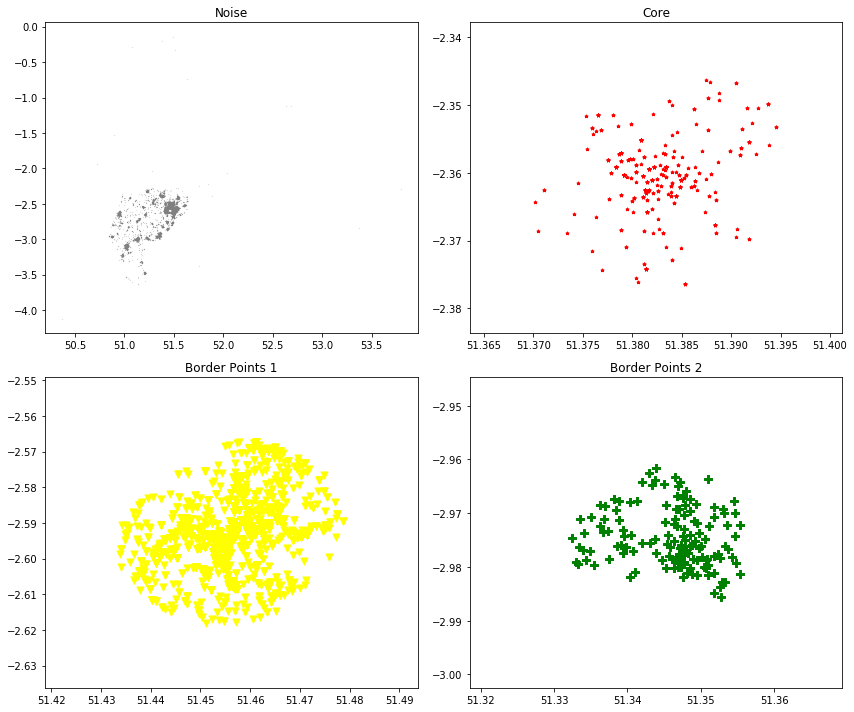

In [98]:
#Creates four polar axes, and accesses them through the returned array
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes[0, 0].scatter(noise['Latitude'], noise['Longitude'],s=0.01, c='gray' )
axes[0, 0].title.set_text('Noise')
axes[0, 1].scatter(core['Latitude'], core['Longitude'],marker= "*", s=10, c='red')
axes[0, 1].title.set_text('Core')
axes[1, 0].scatter(bp1['Latitude'], bp1['Longitude'], marker = "v", s=50, c='yellow')
axes[1, 0].title.set_text('Border Points 1')
axes[1,1].scatter(bp2['Latitude'], bp2['Longitude'],  marker= "P", s=50, c='green')
axes[1, 1].title.set_text('Border Points 2')
plt.tight_layout()
plt.show()

## Spatial Autocorellation

We will Polygon data for this section. Let us first get the data from the dropbox URL

In [0]:
!wget https://www.dropbox.com/s/k2ynddy79k2r46i/ASC_Beats_2016.zip 

In [0]:
!unzip ASC_Beats_2016.zip

In [102]:
boundaries = gpd.read_file('ASC_Beats_2016.shp')
boundaries.head()

,BEAT_CODE,BEAT_NAME,NPA,LPA,PA,geometry
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((356055.9006000003 117502.300599999...
1,AE036,Yeovil,Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((356464.4008999998 118237.800899999...
2,AN010,Weston Villages,Worle,AN - Somerset North,A - Somerset,POLYGON Z ((339021.2017999999 162785.102499999...
3,AW039,Sedgemoor North East,Sedgemoor,AW - Somerset West,A - Somerset,POLYGON Z ((339656.8960999995 156204.096300000...
4,AE022,Wells Rural,Mendip West,AE - Somerset East,A - Somerset,"POLYGON Z ((355607.2001999998 154700.5998 0, 3..."


In [112]:
boundaries.crs, crime_somerset_gdf.crs

({'init': 'epsg:27700'}, {'init': 'epsg:4326'})

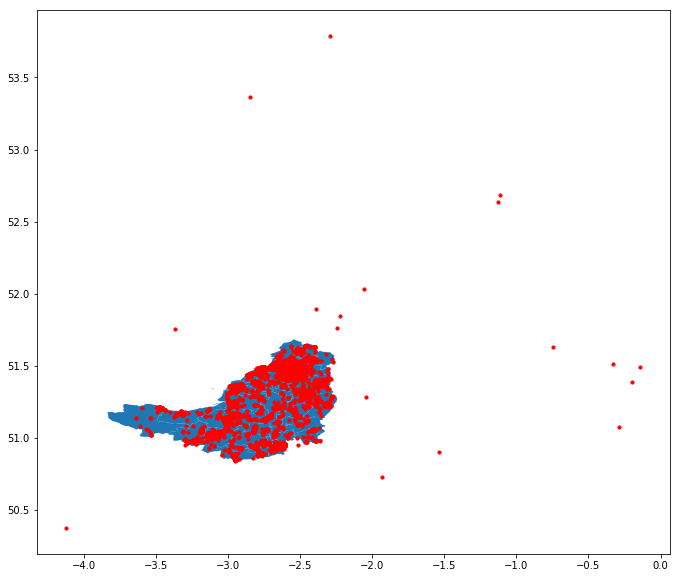

In [113]:
boundaries_4326 = boundaries.to_crs({'init': 'epsg:4326'}) 
fig, ax = plt.subplots(figsize=(12,10))

boundaries_4326.plot(ax=ax)
crime_somerset_gdf.plot(ax=ax, markersize=10, color='red')
plt.savefig('overlayed_map.png')

In [115]:
# Points in Polygon
crimes_with_boundaries = gpd.sjoin(boundaries_4326,crime_somerset_gdf, op='contains' )
crimes_with_boundaries.head()

,BEAT_CODE,BEAT_NAME,NPA,LPA,PA,geometry,index_right,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((-2.627010923440824 50.955264354592...,10230,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.62479,50.954338,On or near Allingham Road,E01029235,South Somerset 014C,Anti-social behaviour
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((-2.627010923440824 50.955264354592...,10241,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.62479,50.954338,On or near Allingham Road,E01029235,South Somerset 014C,Violence and sexual offences
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((-2.627010923440824 50.955264354592...,10240,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.62479,50.954338,On or near Allingham Road,E01029235,South Somerset 014C,Violence and sexual offences
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((-2.627010923440824 50.955264354592...,10239,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.62479,50.954338,On or near Allingham Road,E01029235,South Somerset 014C,Violence and sexual offences
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((-2.627010923440824 50.955264354592...,10232,2019-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.62479,50.954338,On or near Allingham Road,E01029235,South Somerset 014C,Criminal damage and arson


In [116]:
grouped_crimes = crimes_with_boundaries.groupby('BEAT_CODE').size()
grouped_crimes.head()

BEAT_CODE
AE016    169
AE017     30
AE018     15
AE019    112
AE020     33
dtype: int64

In [117]:
df = grouped_crimes.to_frame().reset_index()
df.columns = ['BEAT_CODE', 'CrimeCount']
df.head()

,BEAT_CODE,CrimeCount
0,AE016,169
1,AE017,30
2,AE018,15
3,AE019,112
4,AE020,33


In [118]:
final_result = boundaries.merge(df, on='BEAT_CODE')
final_result.head()

,BEAT_CODE,BEAT_NAME,NPA,LPA,PA,geometry,CrimeCount
0,AE037,Yeovil Centre (One Team),Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((356055.9006000003 117502.300599999...,170
1,AE036,Yeovil,Yeovil,AE - Somerset East,A - Somerset,POLYGON Z ((356464.4008999998 118237.800899999...,251
2,AN010,Weston Villages,Worle,AN - Somerset North,A - Somerset,POLYGON Z ((339021.2017999999 162785.102499999...,38
3,AW039,Sedgemoor North East,Sedgemoor,AW - Somerset West,A - Somerset,POLYGON Z ((339656.8960999995 156204.096300000...,50
4,AE022,Wells Rural,Mendip West,AE - Somerset East,A - Somerset,"POLYGON Z ((355607.2001999998 154700.5998 0, 3...",25


* Choropleth Map of the Crime Count

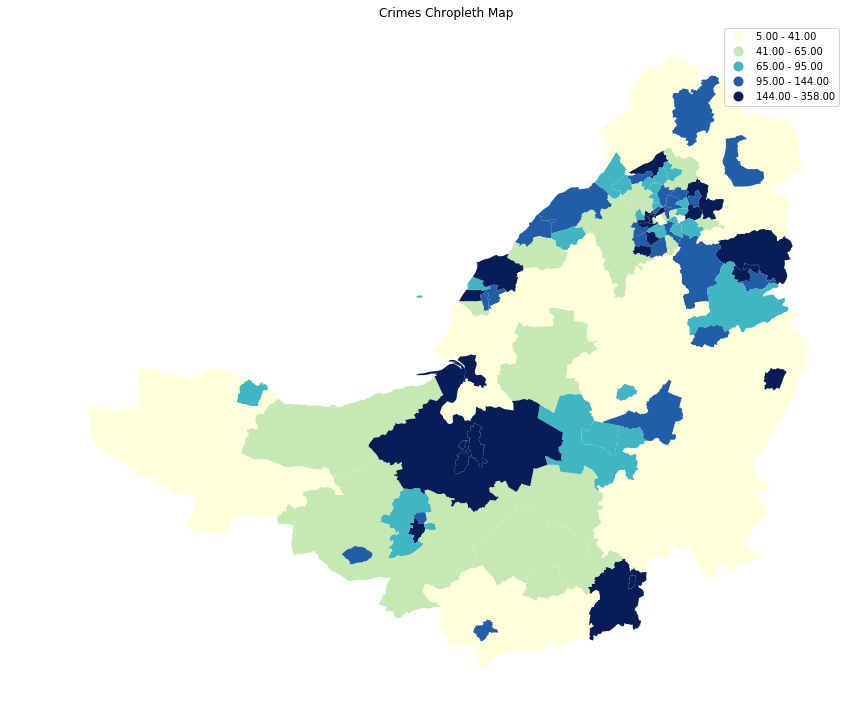

In [119]:
fig, ax = plt.subplots(figsize=(12,10))
final_result.plot(column='CrimeCount', scheme='Quantiles', k=5, cmap='YlGnBu', legend=True, ax=ax);
plt.tight_layout()
ax.set_axis_off()
plt.savefig('choroplethmap.png')
plt.title('Crimes Choropleth Map ')
plt.show()

### GLobal Spatial Autocorrelation

In [0]:
# Create y variable values
y = final_result['CrimeCount'].values

# Sptial lag
ylag = weights.lag_spatial(wq, y)
final_result['ylag'] = ylag

# Get Weights (Queen)
wq = Queen.from_dataframe(final_result)
wq.transform = 'r'

In [128]:

moran = Moran(y, wq)
moran.I

0.25553559979168844

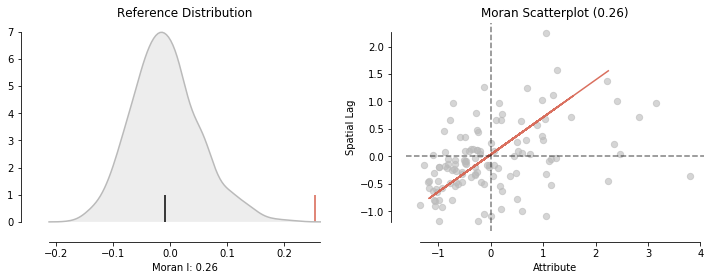

In [129]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.tight_layout()
plt.savefig('moronPlot.png')
plt.show()


In [130]:
moran.p_sim

0.001

## Visualizing Local Autocorrelation with splot - Hot Spots, Cold Spots and Spatial Outliers

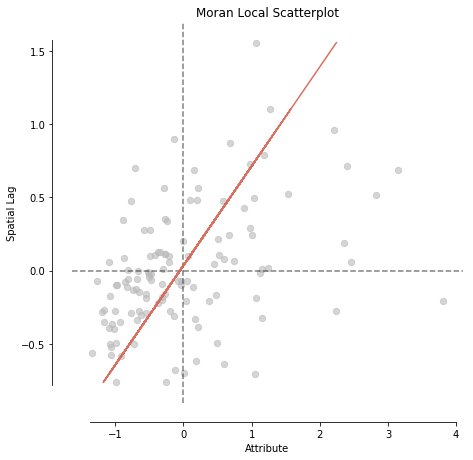

In [134]:
# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
plt.savefig('moron_local.png')
plt.show()

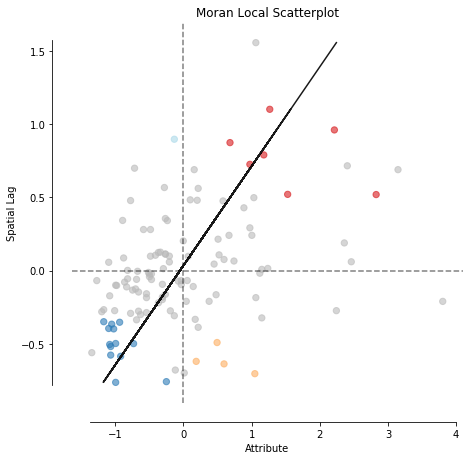

In [136]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
plt.show()

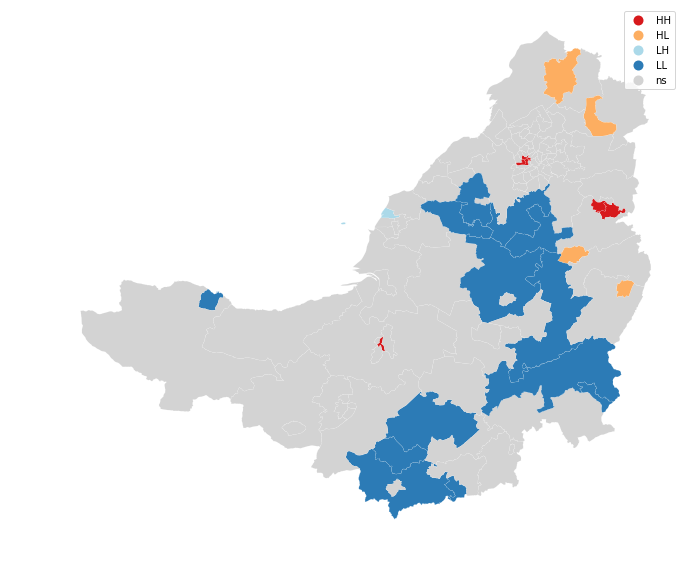

In [138]:
lisa_cluster(moran_loc, final_result, p=0.05, figsize = (10,8))
plt.tight_layout()
plt.savefig('lisa_clusters.png')
plt.show()

# END